In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

%cd /content/drive/My Drive/broutanlab_course/

Mounted at /content/drive
/content/drive/My Drive/broutanlab_course


# Step 1: Extract embeddings from face dataset

In [2]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import pickle
import imutils
import cv2
import os
from imutils import paths

In [3]:
# load our serialized face detector from disk
detector = cv2.dnn.readNetFromCaffe("deploy.prototxt.txt", "res10_300x300_ssd_iter_140000.caffemodel")

In [4]:
# load our serialized face embedding model from disk
embedder = cv2.dnn.readNetFromTorch('openface.nn4.small2.v1.t7')

In [31]:
# grab the paths to the input images in our dataset
imagePaths = list(paths.list_images('dataset5'))
# initialize our lists of extracted facial embeddings and
# corresponding people names
knownEmbeddings = []
knownNames = []
# initialize the total number of faces processed
total = 0

In [32]:
# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
	# extract the person name from the image path
	print("[INFO] processing image {}/{}".format(i + 1,	len(imagePaths)))
	name = imagePath.split(os.path.sep)[-2]
	# load the image, resize it to have a width of 600 pixels (while
	# maintaining the aspect ratio), and then grab the image
	# dimensions
	image = cv2.imread(imagePath)
	image = imutils.resize(image, width=600)
	(h, w) = image.shape[:2]
  # construct a blob from the image
	imageBlob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300),
		(104.0, 177.0, 123.0), swapRB=False, crop=False)
	# apply OpenCV's deep learning-based face detector to localize
	# faces in the input image
	detector.setInput(imageBlob)
	detections = detector.forward()
  # ensure at least one face was found
	if len(detections) > 0:
		# we're making the assumption that each image has only ONE
		# face, so find the bounding box with the largest probability
		i = np.argmax(detections[0, 0, :, 2])
		confidence = detections[0, 0, i, 2]
		# ensure that the detection with the largest probability also
		# means our minimum probability test (thus helping filter out
		# weak detections)
		if confidence > 0.5:
			# compute the (x, y)-coordinates of the bounding box for
			# the face
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")
			# extract the face ROI and grab the ROI dimensions
			face = image[startY:endY, startX:endX]
			(fH, fW) = face.shape[:2]
			# ensure the face width and height are sufficiently large
			if fW < 20 or fH < 20:
				continue
      # construct a blob for the face ROI, then pass the blob
			# through our face embedding model to obtain the 128-d
			# quantification of the face
			faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255,(96, 96), (0, 0, 0), swapRB=True, crop=False)
			embedder.setInput(faceBlob)
			vec = embedder.forward()
			# add the name of the person + corresponding face
			# embedding to their respective lists
			knownNames.append(name)
			knownEmbeddings.append(vec.flatten())
			total += 1

[INFO] processing image 1/40
[INFO] processing image 2/40
[INFO] processing image 3/40
[INFO] processing image 4/40
[INFO] processing image 5/40
[INFO] processing image 6/40
[INFO] processing image 7/40
[INFO] processing image 8/40
[INFO] processing image 9/40
[INFO] processing image 10/40
[INFO] processing image 11/40
[INFO] processing image 12/40
[INFO] processing image 13/40
[INFO] processing image 14/40
[INFO] processing image 15/40
[INFO] processing image 16/40
[INFO] processing image 17/40
[INFO] processing image 18/40
[INFO] processing image 19/40
[INFO] processing image 20/40
[INFO] processing image 21/40
[INFO] processing image 22/40
[INFO] processing image 23/40
[INFO] processing image 24/40
[INFO] processing image 25/40
[INFO] processing image 26/40
[INFO] processing image 27/40
[INFO] processing image 28/40
[INFO] processing image 29/40
[INFO] processing image 30/40
[INFO] processing image 31/40
[INFO] processing image 32/40
[INFO] processing image 33/40
[INFO] processing i

In [33]:
data = knownEmbeddings


In [34]:
le = LabelEncoder()
labels = le.fit_transform(knownNames)

In [35]:
recognizer = SVC(C=1.0, kernel="linear", probability=True)
recognizer.fit(data, labels)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [36]:
labels

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [42]:
imagePaths = list(paths.list_images('test5'))
for (i, imagePath) in enumerate(imagePaths):
  image = cv2.imread(imagePath)
  image = imutils.resize(image, width=600)
  (h, w) = image.shape[:2]
  imageBlob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300),(104.0, 177.0, 123.0), swapRB=False, crop=False)
  detector.setInput(imageBlob)
  detections = detector.forward()
  for i in range(0, detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    if confidence > 0.5:
      box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
      (startX, startY, endX, endY) = box.astype("int")
      face = image[startY:endY, startX:endX]
      (fH, fW) = face.shape[:2]
      if fW < 20 or fH < 20:
        continue
      faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255, (96, 96),
        (0, 0, 0), swapRB=True, crop=False)
      embedder.setInput(faceBlob)
      vec = embedder.forward()
      preds = recognizer.predict_proba(vec)[0]
      j = np.argmax(preds)
      proba = preds[j]
      name = le.classes_[j]
      text = "{}: {:.2f}%".format(name, proba * 100)
      y = startY - 10 if startY - 10 > 10 else startY + 10
      cv2.rectangle(image, (startX, startY), (endX, endY),
        (0, 0, 255), 2)
      cv2.putText(image, text, (startX, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
  cv2_imshow(image)
  cv2.waitKey(0)

Output hidden; open in https://colab.research.google.com to view.

In [38]:
names = os.listdir('test4')
n_classes = len(names)
embeddings = {names[0]:[],names[1]:[], names[2]:[],names[3]:[]}
embeddings

{'Britney Spears': [],
 'Cole Sprouse': [],
 'Lindsay Lohan': [],
 'Robert Downey Jr': []}

In [39]:
imagePaths = list(paths.list_images('test4'))
for (i, imagePath) in enumerate(imagePaths):
  name = imagePath.split(os.path.sep)[-2]
  image = cv2.imread(imagePath)
  image = imutils.resize(image, width=600)
  (h, w) = image.shape[:2]
  imageBlob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300),
		(104.0, 177.0, 123.0), swapRB=False, crop=False)
  detector.setInput(imageBlob)
  detections = detector.forward()
  if len(detections) > 0:
    i = np.argmax(detections[0, 0, :, 2])
    confidence = detections[0, 0, i, 2]
    if confidence > 0.5:
      box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
      (startX, startY, endX, endY) = box.astype("int")
      face = image[startY:endY, startX:endX]
      (fH, fW) = face.shape[:2]
      if fW < 20 or fH < 20:
        continue
      faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255,(96, 96), (0, 0, 0), swapRB=True, crop=False)
      embedder.setInput(faceBlob)
      vec = embedder.forward()
      embeddings[name].append(vec.flatten())
      total += 1

In [40]:

thresholds = np.arange(0.2, 1.0, 0.1)
n = len(thresholds)
f1 = np.zeros(n)
acc = np.zeros(n)
for k, thr in enumerate(thresholds):
  TP, FP, TN, FN = 0, 0, 0, 0
  for person1 in embeddings.keys():
    for i, emb1 in enumerate(embeddings[person1]):
      for person2 in embeddings.keys():
        for j, emb2 in enumerate(embeddings[person2]):
          if person1 == person2 and i == j:
            continue     
          matched = np.linalg.norm(emb1 - emb2) < thr
          if matched:
            if person1 == person2:
              TP += 1
            else:
              FP += 1
          else:
            if person1 == person2:
              FN += 1
            else:
              TN += 1

  acc[k] = (TP + TN) / (TP + FP + TN + FN)
  print(k, thr,acc[k])


0 0.2 0.7894736842105263
1 0.30000000000000004 0.7894736842105263
2 0.4000000000000001 0.7894736842105263
3 0.5000000000000001 0.7894736842105263
4 0.6000000000000001 0.7842105263157895
5 0.7000000000000002 0.8157894736842105
6 0.8000000000000003 0.8052631578947368
7 0.9000000000000001 0.7315789473684211


Optimal threshold = 0.7000000000000002 Accuracy = 0.8157894736842105


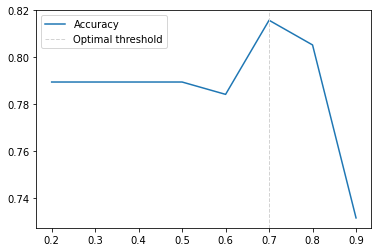

In [41]:
from matplotlib import pyplot as plt
opt_idx = np.argmax(acc)
opt_tau = thresholds[opt_idx]
plt.plot(thresholds, acc,label='Accuracy')
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Optimal threshold')
plt.legend();
print('Optimal threshold = {} Accuracy = {}'.format(opt_tau, acc[opt_idx]))